#### This notebook is based on this link:https://github.com/makcedward/nlp/blob/master/sample/nlp-embeddings-sentence-elmo.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

In [14]:
from keras import backend as K
from keras.models import Model, Input, load_model
from keras.layers import Input, Dense, Embedding, BatchNormalization, \
                Concatenate, LSTM, Lambda,  Activation, \
                Conv1D, MaxPooling1D, Flatten, Reshape, Dropout, CuDNNLSTM
from keras.optimizers import RMSprop, Adam, Adamax, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras.layers.merge import add
from keras.utils import to_categorical

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

#### Custom Functions

In [6]:
from src.callbacks import PlotCurves
from src.eval_metrics import f1_macro, f1_micro 
from src.load_data import load_data

### Load Data

In [7]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [8]:
n_tags = 2
batch_size = 32

In [9]:
def get_input(data_, n_tags, is_test=False):
    
    X = np.array([sentence['sentence'].replace('\n', '').strip().lower() 
                  for article in data_ 
                  for sentence in article['sentences']])

    y = np.array([sentence['label'] 
                  for article in data_
                  for sentence in article['sentences']])

    if not is_test:
        y = to_categorical(y, num_classes=n_tags)
    
    return X, y

In [10]:
X_tra, y_tra = get_input(train_data, n_tags, False)
X_val, y_val = get_input(valid_data, n_tags, False)
X_test, y_test = get_input(test_data, n_tags, True)

In [11]:
X_tra.shape, y_tra.shape

((3582,), (3582, 2))

X_tra_val = np.concatenate((X_tra, X_val))

vocab = set()
for sentence in X_tra_val:
    tokens = sentence.split(' ')
    for token in tokens:
        vocab.add(token)

vocab_size = len(vocab)
print('Vocab Size: %d' % (vocab_size))

max_sentence_length = 100
word2Idx = {'<padding>': 0, '<unknown>': 1}
idx2word = {0: '<padding>', 1: '<unknown>'}

def preprocess(text, word2Idx, idx2word, training=False):
    if training:
        for sentence in text:
            tokens = sentence.split(' ')

            for token in tokens:
                if token not in word2Idx:
                    word2Idx[token] = len(word2Idx)
                    idx2word[len(word2Idx)-1] = token


    word_vectors = np.zeros((len(text), max_sentence_length))
    sentence_vectors = []
    
    for i, sentence in enumerate(text):
        ids = []
        words = []
        tokens = sentence.split(' ')
        for token in tokens:
            if token in word2Idx:
                ids.append(word2Idx[token])
                words.append(token)
            else:
                ids.append(word2Idx['<unknown>'])
                words.append('<unknown>')
                
            if len(ids) >= max_sentence_length:
                break

        for i in range(max_sentence_length - len(ids)):
            ids.append(word2Idx['<padding>'])
            words.append('<padding>')

        word_vectors[i] = np.asarray(ids)
        sentence_vectors.append(' '.join(words))

    sentence_vectors = np.asarray(sentence_vectors)
    
    return word2Idx, idx2word, word_vectors, sentence_vectors



word2Idx, idx2word, x_train_words, x_train_sentences = preprocess(
    text=X_tra, word2Idx=word2Idx, idx2word=idx2word, training=True)
print('x_train_words.shape:', x_train_words.shape)

word2Idx, idx2word, x_val_words, x_val_sentences = preprocess(
    text=X_val, word2Idx=word2Idx, idx2word=idx2word, training=False)
print('x_train_words.shape:', x_val_words.shape)

word2Idx, idx2word, x_test_words, x_test_sentences = preprocess(
    text=X_test, word2Idx=word2Idx, idx2word=idx2word, training=False)
print('x_test_words.shape:', x_test_words.shape)

### Load ELMo

In [12]:
sess = tf.Session()
K.set_session(sess)

elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["elmo"]

def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

def build_model_19(n_tags):
    elmo_input_layer = Input(shape=(1,), dtype="string")
    x = Lambda(ELMoEmbedding, output_shape=(1024,))(elmo_input_layer)
    x = Dense(256, activation='relu')(x)
    x = Dense(2, activation='sigmoid')(x)

    return Model(inputs=elmo_input_layer, outputs=x)

In [13]:
def build_model_20(n_tags):
    
    word_input_layer = Input(shape=(None, ), dtype='int32')
    elmo_input_layer = Input(shape=(None, ), dtype="string")

    word_output_layer = Embedding(
        input_dim=vocab_size, output_dim=256)(word_input_layer)

    elmo_output_layer = Lambda(ELMoEmbedding, output_shape=(None, 1024))(elmo_input_layer)

    output_layer = Concatenate()(
        [word_output_layer, elmo_output_layer])

    output_layer = BatchNormalization()(output_layer)

    output_layer = LSTM(256, dropout=0.2, recurrent_dropout=0.2)(output_layer)
    output_layer = Dense(2, activation='sigmoid')(output_layer)

    return Model(inputs=[word_input_layer, elmo_input_layer], outputs=output_layer)

In [17]:
def build_model_24(n_tags):
    
    elmo_input_layer = Input(shape=(None, ), dtype="string")
    x = Lambda(ELMoEmbedding, output_shape=(None, 1024))(elmo_input_layer)
    x = LSTM(256)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(2, activation='sigmoid')(x)

    return Model(inputs=elmo_input_layer, outputs=x)

In [19]:
def build_model_26(n_tags):
    
    elmo_input_layer = Input(shape=(None, ), dtype="string")
    x = Lambda(ELMoEmbedding, output_shape=(None, 1024))(elmo_input_layer)
    x = LSTM(512, dropout=0.2, recurrent_dropout=0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(2, activation='sigmoid')(x)

    return Model(inputs=elmo_input_layer, outputs=x)

In [20]:
def build_model_27(n_tags):
    
    elmo_input_layer = Input(shape=(None, ), dtype="string")
    x = Lambda(ELMoEmbedding, output_shape=(None, 1024))(elmo_input_layer)
    x = LSTM(512)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(2, activation='sigmoid')(x)

    return Model(inputs=elmo_input_layer, outputs=x)

In [21]:
def build_model_28(n_tags):
    
    elmo_input_layer = Input(shape=(None, ), dtype="string")
    x = Lambda(ELMoEmbedding, output_shape=(None, 1024))(elmo_input_layer)
    x = BatchNormalization()(x)
    x = LSTM(512, dropout=0.2, recurrent_dropout=0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(2, activation='sigmoid')(x)

    return Model(inputs=elmo_input_layer, outputs=x)

In [ ]:
def build_model_38(n_tags):
    
    elmo_input_layer = Input(shape=(None, ), dtype="string")
    x = Lambda(ELMoEmbedding, output_shape=(None, 1024))(elmo_input_layer)
    x = CuDNNLSTM(512, return_sequences=True)(x)
    x = CuDNNLSTM(256)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(2, activation='sigmoid')(x)

    return Model(inputs=elmo_input_layer, outputs=x)

In [ ]:
def build_model_39(n_tags):
    
    elmo_input_layer = Input(shape=(None, ), dtype="string")
    x = Lambda(ELMoEmbedding, output_shape=(None, 1024))(elmo_input_layer)
    x = CuDNNLSTM(256, return_sequences=True)(x)
    x = CuDNNLSTM(128)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(2, activation='sigmoid')(x)

    return Model(inputs=elmo_input_layer, outputs=x)

In [31]:
learningrate=0.01
optimizer = Adam(lr=learningrate)
optimizer_str = 'adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]


In [32]:
model = build_model_36(n_tags)
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

W0915 22:07:48.266646 140141978374272 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0915 22:07:48.267500 140141978374272 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0915 22:07:48.531036 140141978374272 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0915 22:07:48.685752 140141978374272 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/optimizers.py:790: T

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 590,594
Trainable params: 590,594
Non-trainable params: 0
_________________________________________________________________


In [33]:
model_name = 'RQ1_aion_elmo_model_36' + \
             '_' + optimizer_str +  \
             '_lr_' + str(learningrate) +  \
             '_lrreduction' + \
             '_loss_' + loss

model_main = './Model/' + model_name.split('model')[0] + 'model/'
model_dir = os.path.join(model_main, model_name)
score_file = os.path.join(model_main, 'model_performances.csv')
results_file = os.path.join(model_dir, 'model_results_file.txt')

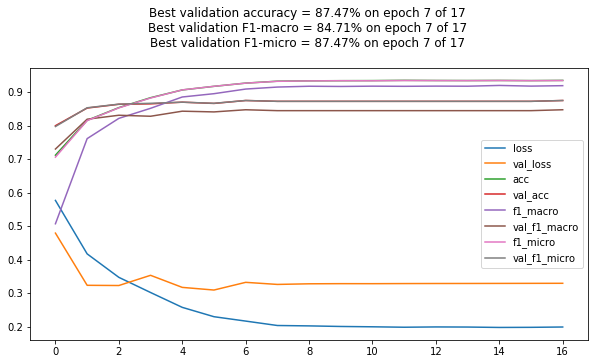

In [34]:
# [x_train_words, x_train_sentences]
# [x_val_words, x_val_sentences]
model.fit(X_tra, y_tra, 
          epochs=50, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val), 
          callbacks=[
              PlotCurves(model_name=model_name, model_dir=model_dir, jnote=True),
              ReduceLROnPlateau(monitor='val_f1_macro', patience=3, 
                                factor=0.1, min_lr=0.00001),
              EarlyStopping(monitor='val_f1_macro', min_delta=0, patience=10, mode='max')
          ])

#### Load Best Model

In [35]:
model_name

'RQ1_aion_elmo_model_36_adam_lr_0.01_lrreduction_loss_binary_crossentropy'

In [45]:
best_model = load_model(os.path.join(model_dir, model_name + '_best_f1_macro_model.h5'), 
                        custom_objects={'elmo':elmo, 'tf':tf, 'f1_macro':f1_macro, 'f1_micro':f1_micro})

### Evaluation

In [48]:
#[x_val_words, x_val_sentences]
y_preds = best_model.predict(X_val, batch_size=batch_size)
y_preds = np.argmax(y_preds, axis=1)

y_val = np.argmax(y_val, axis=1)

In [49]:
clsrpt_val = classification_report(y_val, y_preds)
sfm_val = scikit_f1_score(y_val, y_preds, average='macro')
    
print(clsrpt_val)
print('\nScikit_F1_Macro:', sfm_val)

with open(results_file, 'w') as f:
    f.write('\n---------------- Validation ----------------\n')

with open(results_file, 'a') as f:
    f.write('\n' + clsrpt_val + '\n' + str(sfm_val) + '\n\n')

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       269
           1       0.81      0.81      0.81       130

   micro avg       0.87      0.87      0.87       399
   macro avg       0.86      0.86      0.86       399
weighted avg       0.87      0.87      0.87       399


Scikit_F1_Macro: 0.857377752359165


In [50]:
# X, y = get_input(data_, n_tags, True)
# [x_test_words, x_test_sentences]
y_preds = best_model.predict(X_test, batch_size=batch_size)
y_preds = np.argmax(y_preds, axis=1)

In [51]:
clsrpt_test = classification_report(y_test, y_preds)
sfm_test = scikit_f1_score(y_test, y_preds, average='macro')
    
print(clsrpt_test)
print('\nScikit_F1_Macro:', sfm_test)

with open(results_file, 'a') as f:
    f.write('\n---------------- Test ----------------\n')

with open(results_file, 'a') as f:
    f.write('\n' + clsrpt_test + '\n' + str(sfm_test) + '\n\n')

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       325
           1       0.74      0.49      0.59       116

   micro avg       0.82      0.82      0.82       441
   macro avg       0.79      0.71      0.74       441
weighted avg       0.81      0.82      0.81       441


Scikit_F1_Macro: 0.7380073245749266


In [52]:
if not os.path.exists(score_file):
    with open(score_file, 'w') as scrf:
        scrf.write("model_name,val_f1_macro,test_f1_macro\n")

with open(score_file, 'a') as scrf:
    scrf.write(
        '\n' + \
        model_name + ',' + \
        str(sfm_val) + ',' + \
        str(sfm_test) + '\n'
    )